In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
import re
def tablelize(star):
    string = star.render_latex().replace("\\begin{table}[!htbp] \\centering","").replace("\\end{table}","").replace("_","\\_")
    return re.sub(r"\(df=[\d; ]*\)", "", string)

<Axes: xlabel='distance', ylabel='Count'>

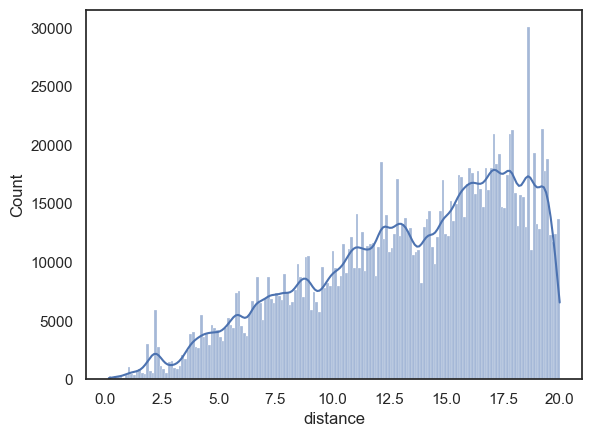

In [3]:
log=np.log
sns.set_theme(style="white")
original_df = pd.read_parquet("../data/olsups.parquet")
sns.histplot(original_df["distance"], kde=True)

In [4]:
df = original_df[original_df["保险金额"] > 0].copy()
df["历史投保"] = df["上年保单号"].map(lambda x: 1 if x else 0)
df = df[(df["t"] > 1999) & (df["t"] < 2014)]
df["ti"] = df["t"].astype(str)
df["是否理赔"] = df["total_claim"].map(lambda x: 1 if x > 0 else 0)

df.rename(
    columns={
        "保费合计": "Premium",
        "保险金额": "Coverage",
        "middle": "Neighbor",
        "treated": "Disaster",
        "after": "Post",
        "历史投保": "Prem_before",
        "保险财产购置价": "Price",
        "建筑面积": "Area",
        "是否理赔":"Claim",
        "保险密度": "Density",
        "保险深度": "Penetration",
        "gdp": "GDP"
    },
    inplace=True,
)
df["Price"]=df["Price"]/10000
columns = ['Premium', 'Coverage', 'Price', 'Density', 'Penetration', 'GDP']
minmax=[0.025,0.975]
quantiles=df[columns].quantile(minmax)
for column in columns:
    df=df[(df[column]>quantiles.loc[minmax[0], column]) & (df[column]<quantiles.loc[minmax[1], column])]
df=df[df["Price"]>0]
df=df.copy()
# df.to_parquet("../data/df.parquet")
df.head()

,省份,站名,minpost,maxpost,total_claim,下年保单号,Neighbor,区站号,区站经度,区站纬度,...,Premium,Price,Area,t,GDP,Density,Penetration,Prem_before,ti,Claim
0,江苏,南通,0.0,0.0,0.0,,0,58259,120.51,32.01,...,648.0,48.000000,227.860001,2010,0.202227,396.356616,0.753691,0,2010,0
1,江苏,南通,0.0,0.0,0.0,,0,58259,120.51,32.01,...,1134.0,90.000000,159.910004,2010,41425.480000,396.356616,0.753691,0,2010,0
2,江苏,南通,0.0,0.0,0.0,,0,58259,120.51,32.01,...,1134.0,90.000000,159.910004,2010,0.202227,396.356616,0.753691,0,2010,0
3,江苏,南通,0.0,0.0,0.0,,0,58259,120.51,32.01,...,1077.0,71.199997,184.169998,2010,41425.480000,396.356616,0.753691,0,2010,0
4,江苏,南通,0.0,0.0,0.0,,0,58259,120.51,32.01,...,1077.0,71.199997,184.169998,2010,0.202227,396.356616,0.753691,0,2010,0


## DID 回归

### 远vs中

In [4]:
model1 = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Disaster"]==0)]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                 5.356e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        14:08:20   Log-Likelihood:            -6.7273e+05
No. Observations:              654504   AIC:                         1.345e+06
Df Residuals:                  654496   BIC:                         1.346e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.0413      0.004   2798.434      0.000      11.034      11.049
Neighbor            -0.2008      0.013    -15.445      0.000      -0.226      -0.175
Post                 0.1033      0.003     34.310      0.000       0.097       0.109
Neighbor:Post        0.2424      0.014     17.786      0.000       0.216       0.269
Prem_before          0.2395      0.005     47.398      0.000       0.230       0.249
log(Price)           0.3642      0.001    541.491      0.000       0.363       0.366
log(Penetration)     0.6731      0.004    170.840      0.000       0.665       0.681
log(GDP)             0.0007      0.000      4.663      0.000       0.000       0.001
==============================================================================
Omnibus:                   359298.405   Durbin-Watson:                   0.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7923050.019
Skew:                           2.189   Prob(JB):                         0.00
Kurtosis:                      19.473   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
raws1 = smf.ols("log(Coverage) ~ Neighbor*Post", data=df[(df["Disaster"]==0)]).fit()
stargazer = Stargazer([raws1, model1])
stargazer


In [7]:
with open("../lib/table/did1.tex", "w") as f:
    f.write(tablelize(stargazer))

### 远vs近

In [5]:
model2 = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 6.352e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        14:08:39   Log-Likelihood:            -7.1244e+05
No. Observations:              709271   AIC:                         1.425e+06
Df Residuals:                  709263   BIC:                         1.425e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.9849      0.004   2873.265      0.000      10.977      10.992
Disaster            -0.0066      0.005     -1.437      0.151      -0.016       0.002
Post                 0.0996      0.003     33.835      0.000       0.094       0.105
Disaster:Post       -0.1453      0.005    -26.512      0.000      -0.156      -0.135
Prem_before          0.2444      0.005     48.083      0.000       0.234       0.254
log(Price)           0.3823      0.001    588.576      0.000       0.381       0.384
log(Penetration)     0.6809      0.004    184.430      0.000       0.674       0.688
log(GDP)             0.0007      0.000      5.245      0.000       0.000       0.001
==============================================================================
Omnibus:                   422373.452   Durbin-Watson:                   0.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11762881.522
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                      22.376   Cond. No.                         67.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
raws2 = smf.ols("log(Coverage) ~ Disaster*Post", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([raws2, model2])
stargazer


In [9]:
with open("../lib/table/did2.tex", "w") as f:
    f.write(tablelize(stargazer))

## 描述性统计

In [10]:
descol=["Coverage","Disaster","Neighbor","Post","Prem_before","Price","Area"]
todesc=df[descol].astype(float).describe()
todesc=todesc.astype(int).astype(str).T.rename(columns={"50%":"median"})
with open("../lib/table/desc.tex", "w") as f:
    print(todesc[['count', 'mean', 'std', 'min', 'median', 'max']].to_latex().replace("_","\\_"), file=f)
with open("../lib/table/corr.tex", "w") as f:
    print(df[descol].corr().to_latex().replace("_","\\_"), file=f)

<Axes: xlabel='Coverage', ylabel='Count'>

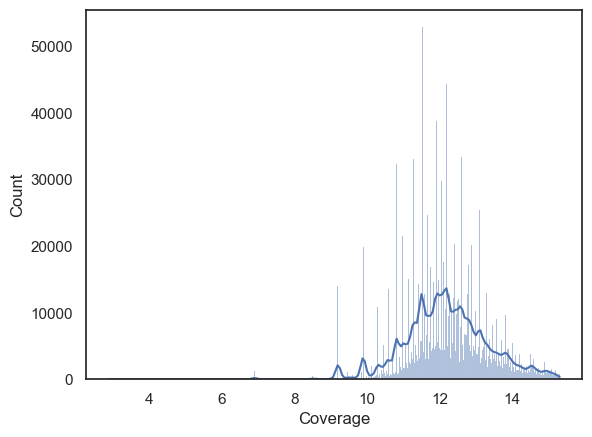

In [11]:
x=0.01
coverage=original_df["保险金额"]
coverage.name="Coverage"
coverage=coverage[coverage.between(coverage.quantile(x)+10,coverage.quantile(1-x))]
coverage=log(coverage)
sns.histplot(coverage,kde=True)

## 进一步分析

In [10]:
df["claimed"]=df["total_claim"].map(lambda x: 1 if x>0 else 0)
claims = smf.logit("claimed ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
rawsclaim = smf.logit("claimed ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([rawsclaim, claims])
with open("../lib/table/claims.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.010120
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010129
         Iterations 13


In [12]:
treated = df[df["Neighbor"]==0].copy()
treated["renew"]=treated["下年保单号"].map(lambda x: 1 if x else 0)
renew = smf.logit("renew ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
rawsrenew = smf.logit("renew  ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
stargazer = Stargazer([rawsclaim,claims,rawsrenew, renew])
stargazer.custom_columns(['Claim', 'Claim', "Renew", "Renew"])
with open("../lib/table/renew.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.069718
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070766
         Iterations 11


## 稳健性测试

In [14]:
# def robust_test(category="Disaster", cond=False):
#     df["treated"]=df[category]
#     df["Quarter_before"] = df["maxpost"].map(
#         lambda x: x // 90  if (x < 0 and x > -365) else None
#     )
#     df["Quarter_after"] = df["minpost"].map(
#         lambda x: x // 90 if (x > 0 and x < 365) else None
#     )
#     if category == "Disaster":
#         df["Quarter_before"] = df["Quarter_after"].fillna(
#             (
#                 pd.to_datetime(df["maxraining_after"])
#                 - pd.to_datetime(df["保险起期"], unit="s")
#             ).dt.days.map(lambda x: x // 90 if (x <= 365 and x >= 0) else None)
#         )
#         df["Quarter_after"] = df["Quarter_before"].fillna(
#             -(
#                 pd.to_datetime(df["保险起期"], unit="s")
#                 - pd.to_datetime(df["maxraining_before"])
#             ).dt.days.map(lambda x: x // 90  if (x <= 365 and x > 0) else None)
#         )
#     df["Quarter"] = df["Quarter_before"].fillna(df["Quarter_after"])
#     y = -4 if category == "Disaster" else -3
#     data = df[df["Quarter"].between(y, 0)].copy()
#     reg_str = "log(Coverage) ~ treated*C(Quarter)"
#     if cond:
#         reg_str += "+Prem_before+Price+Area"
#     model = smf.ols(
#         reg_str,
#         data=data,
#     ).fit()
#     robust=df[["Disaster","Neighbor", "Quarter", "Coverage"]]
#     robust.to_parquet(f"../data/robust_{category}.parquet")
#     return model


# stargazer = Stargazer(
#     [robust_test(i, j) for i in ["Disaster", "Neighbor"] for j in [False, True]]
# )
# # stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
# # with open("../lib/table/robust.tex", "w") as f:
# #     f.write(tablelize(stargazer))
# stargazer

In [15]:
df["Pre"]=df["Disaster"]*((pd.to_datetime(df['record_date'])-pd.to_datetime(df['保险起期']))).dt.days//90+(df["maxpost"]//90)
# df["Pre"]=df["Pre"].map(lambda x: 1 if x>=-4 and x<0 else 0)
# df["After"]=1-df["Pre"]
stars=[]
for category in ["Disaster","Neighbor"]:
    noncat = "Disaster" if category=="Neighbor" else "Neighbor"
    for post in ["", "Post"]:
        if not post:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+Prem_before+log(Price)+log(GDP)+(Penetration)"
        else:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+{category}*Post+Prem_before+log(Price)+(GDP)+log(Penetration)"
        model = smf.ols(regstr,data=df[(df[noncat]==0)&(df["Post"]==1)]).fit()
        stars.append(model)
stargazer=Stargazer(stars)
with open("../lib/table/robust.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

## 异质性分析

In [16]:
# 分东中西部

hdf=df.copy()
east ={i:"East" for i in "北京、天津、河北、上海、江苏、浙江、福建、山东、广东、辽宁、海南".split("、")}
middle ={i:"West" for i in "山西、吉林、黑龙江、安徽、江西、河南、湖北、湖南".split("、")}
west ={i:"Middle" for i in "重庆、四川、内蒙古、广西、贵州、云南、西藏、陕西、甘肃、青海、宁夏、新疆".split("、")}
northeast ={i:"NorthEast" for i in "".split("、")}
provinces = {**east,**middle,**west,**northeast}
hdf["region"]=hdf["省份"].map(provinces)
stars = []
column = []
col=[]
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer

In [20]:
log(df["GDP"])

0          -1.598367
1          10.631651
2          -1.598367
3          10.631651
4          -1.598367
             ...    
1559915    -1.644539
1559918     9.839148
1559919    -1.644539
1559920     9.839148
1559921    -1.644539
Name: GDP, Length: 741442, dtype: float64

In [17]:
# stars = []
# column = []
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# stargazer.add_line("Region", column, "bt")
# stargazer.add_line("Treated", col, "bt")
with open("../lib/table/het_geo.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [21]:
hdf=df.copy()
hdf = hdf[(hdf["t"]>2002)&(hdf["t"]<2013)]
stars = []
column = []
col = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2008 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
# stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [22]:
# stars = []
# column = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2009 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [23]:
stars = []
column = []
for region, region_df in df.groupby("t"):
    column.append(region)
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# with open("../lib/table/het_time.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [28]:
groups = "Coverage"
hdf = df[df[groups] > 0]
quantiles = hdf[groups].quantile([0.00, 0.35, 0.65, 1]).values.tolist()
hdf = hdf[hdf[groups].between(quantiles[0], quantiles[-1])]
stars = []

for category in ["Disaster", "Neighbor"]:
    for i in range(len(quantiles) - 1):
        noncat = "Neighbor" if category == "Disaster" else "Disaster"
        model = smf.ols(
            f"log(Coverage) ~ {category}*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)",
            data=hdf[
                (hdf[groups].between(quantiles[i], quantiles[i + 1]))
                & (hdf[noncat] == 0)
            ],
        ).fit()
        stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(["low", "mid", "high"]*2)
stargazer

In [30]:
with open("../lib/table/het_cov.tex", "w") as f:
    f.write(tablelize(stargazer))